In [4]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Permute, Activation, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-03-23 14:37:13.363309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


In [6]:
img_x, img_y = (576, 576)
dx = 48
filelst = os.listdir(r'DRIVE/training/images/')
filelst = ['DRIVE/training/images/'+v for v in filelst]
imgs = [cv2.imread(file) for file in filelst]
filelst = os.listdir(r'DRIVE/training/1st_manual/')
filelst = ['DRIVE/training/1st_manual/'+v for v in filelst]
manuals = [np.asarray(Image.open(file)) for file in filelst]
imgs = [cv2.resize(v,(img_x, img_y)) for v in imgs]
manuals = [cv2.resize(v,(img_x, img_y)) for v in manuals]
X_train = np.array(imgs)  
Y_train = np.array(manuals)
X_train = X_train.astype('float32')/255.
Y_train = Y_train.astype('float32')/255.
X_train = X_train[...,1] # the G channel
X_train = np.array([[X_train[:,v*dx:(v+1)*dx, vv*dx:(vv+1)*dx] for v in range(img_y//dx)] for vv in range(img_x//dx)]).reshape(-1,dx,dx)[:,np.newaxis,...]
Y_train = np.array([[Y_train[:,v*dx:(v+1)*dx, vv*dx:(vv+1)*dx] for v in range(img_y//dx)] for vv in range(img_x//dx)]).reshape(-1,dx*dx)[...,np.newaxis]
temp = 1-Y_train
Y_train = np.concatenate([Y_train,temp],axis=2)

In [7]:
def unet_model(n_ch,patch_height,patch_width):
   inputs = Input(shape=(n_ch,patch_height,patch_width))
   conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
   conv1 = Dropout(0.2)(conv1)
   conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
   pool1 = MaxPooling2D((2, 2))(conv1)
   
   conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
   conv2 = Dropout(0.2)(conv2)
   conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
   pool2 = MaxPooling2D((2, 2))(conv2)
   
   conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
   conv3 = Dropout(0.2)(conv3)
   conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)
   
   up1 = UpSampling2D(size=(2, 2))(conv3)
   up1 = concatenate([conv2,up1],axis=1)
   conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
   conv4 = Dropout(0.2)(conv4)
   conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)

   up2 = UpSampling2D(size=(2, 2))(conv4)
   up2 = concatenate([conv1,up2], axis=1)
   conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
   conv5 = Dropout(0.2)(conv5)
   conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)

   conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
   conv6 = Reshape((2,patch_height*patch_width))(conv6)
   conv6 = Permute((2,1))(conv6)
   
   conv7 = Activation('softmax')(conv6)
   
   model = Model(inputs=inputs, outputs=conv7)
   return model
       
model = unet_model(X_train.shape[1],X_train.shape[2],X_train.shape[3])
model.summary()

2024-03-23 14:37:49.890111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 48, 48)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 48, 48)   320         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32, 48, 48)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 48, 48)   9248        ['dropout[0][0]']                
                                                                                              

In [8]:
checkpointer = ModelCheckpoint(filepath='best_weights.h5', verbose=1, monitor='val_acc', 
                              mode='auto', save_best_only=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=200, verbose=2, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

# 获取训练集和验证集的损失和准确率
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Epoch 1/200
36/36 - 1s - loss: 0.0790 - accuracy: 0.9707 - val_loss: 0.0879 - val_accuracy: 0.9725 - 819ms/epoch - 23ms/step
Epoch 2/200
36/36 - 1s - loss: 0.0787 - accuracy: 0.9707 - val_loss: 0.0921 - val_accuracy: 0.9725 - 753ms/epoch - 21ms/step
Epoch 3/200
36/36 - 1s - loss: 0.0791 - accuracy: 0.9706 - val_loss: 0.0927 - val_accuracy: 0.9727 - 759ms/epoch - 21ms/step
Epoch 4/200
36/36 - 1s - loss: 0.0798 - accuracy: 0.9705 - val_loss: 0.0872 - val_accuracy: 0.9727 - 754ms/epoch - 21ms/step
Epoch 5/200
36/36 - 1s - loss: 0.0788 - accuracy: 0.9707 - val_loss: 0.0940 - val_accuracy: 0.9726 - 750ms/epoch - 21ms/step
Epoch 6/200
36/36 - 1s - loss: 0.0790 - accuracy: 0.9707 - val_loss: 0.0866 - val_accuracy: 0.9732 - 757ms/epoch - 21ms/step
Epoch 7/200
36/36 - 1s - loss: 0.0783 - accuracy: 0.9709 - val_loss: 0.0879 - val_accuracy: 0.9731 - 753ms/epoch - 21ms/step
Epoch 8/200
36/36 - 1s - loss: 0.0779 - accuracy: 0.9710 - val_loss: 0.0849 - val_accuracy: 0.9735 - 758ms/epoch - 21ms/step


In [19]:
imgs = cv2.imread(r'DRIVE/test/images/01_test.tif')[...,1] #the G channel
imgs = cv2.resize(imgs,(img_x, img_y))
manuals = np.asarray(Image.open(r'DRIVE/test/1st_manual/01_manual1.gif'))
X_test = imgs.astype('float32')/255.
Y_test = manuals.astype('float32')/255.
X_test = np.array([[X_test[v*dx:(v+1)*dx, vv*dx:(vv+1)*dx] for v in range(img_y//dx)] for vv in range(img_x//dx)]).reshape(-1,dx,dx)[:,np.newaxis,...]
# model.load_weights('best_weights.h5')
Y_pred = model.predict(X_test)
Y_pred = Y_pred[...,0].reshape(img_x//dx,img_y//dx,dx,dx)
Y_pred = [Y_pred[:,v,...] for v in range(img_x//dx)]
Y_pred = np.concatenate(np.concatenate(Y_pred,axis=1),axis=1)
Y_pred = cv2.resize(Y_pred,(Y_test.shape[1], Y_test.shape[0]))

5/5 [==============================] - 0s 4ms/step


In [20]:
plt.figure(figsize=(6,6))
plt.imshow(Y_pred)
plt.savefig('unet_predicted_image.png')  # 保存预测的图像
plt.close()  # 关闭当前图形以释放内存

plt.figure(figsize=(6,6))
plt.imshow(Y_test)
plt.savefig('unet_ground_truth_image.png')  # 保存真实的图像
plt.close()  # 关闭当前图形以释放内存

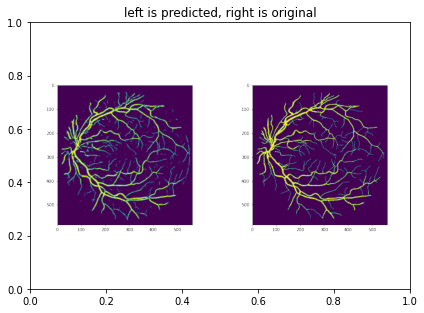

In [21]:
import matplotlib.pyplot as plt

image1 = plt.imread('unet_predicted_image.png')
image2 = plt.imread('unet_ground_truth_image.png')

fig = plt.figure()
plt.title("left is predicted, right is original")

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image1)
ax1.axis('off')  # 关闭坐标轴

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image2)
ax2.axis('off')  # 关闭坐标轴

plt.tight_layout()

plt.savefig('merged_unet_image.png')
plt.show()

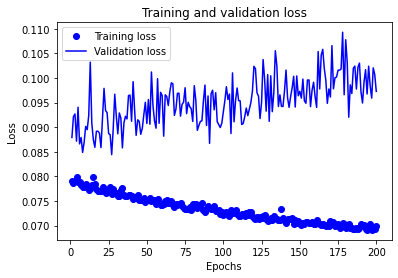

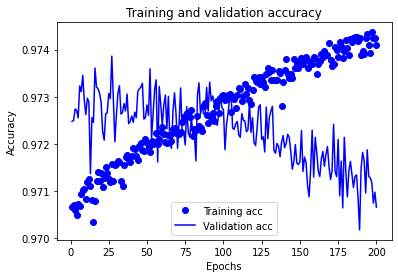

In [22]:
# 训练过程作图
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('unet_loss.png')
plt.show()

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('unet_acc.png')
plt.show()